In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [29]:
import tensorflow as tf
import keras
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [21]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X_train_full = train.iloc[:, 1:]
X_train_full = X_train_full.values.reshape((-1, 28, 28, 1))
y_train_full = train.iloc[:, 0]

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=15,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.3,
                                  zoom_range = 0.3)
valid_datagen = ImageDataGenerator(rescale=1./255)

traingen = train_datagen.flow(X_train, y_train, batch_size=32)
validgen = valid_datagen.flow(X_train, y_train, batch_size=32)

In [31]:
def build_model(n_hidden=1, filters=64, learning_rate=3e-3, dropout_rate=0.5):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(2))
    for layer in range(n_hidden-1):
        model.add(keras.layers.Conv2D(filters*(layer+1), 3, activation='relu', padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

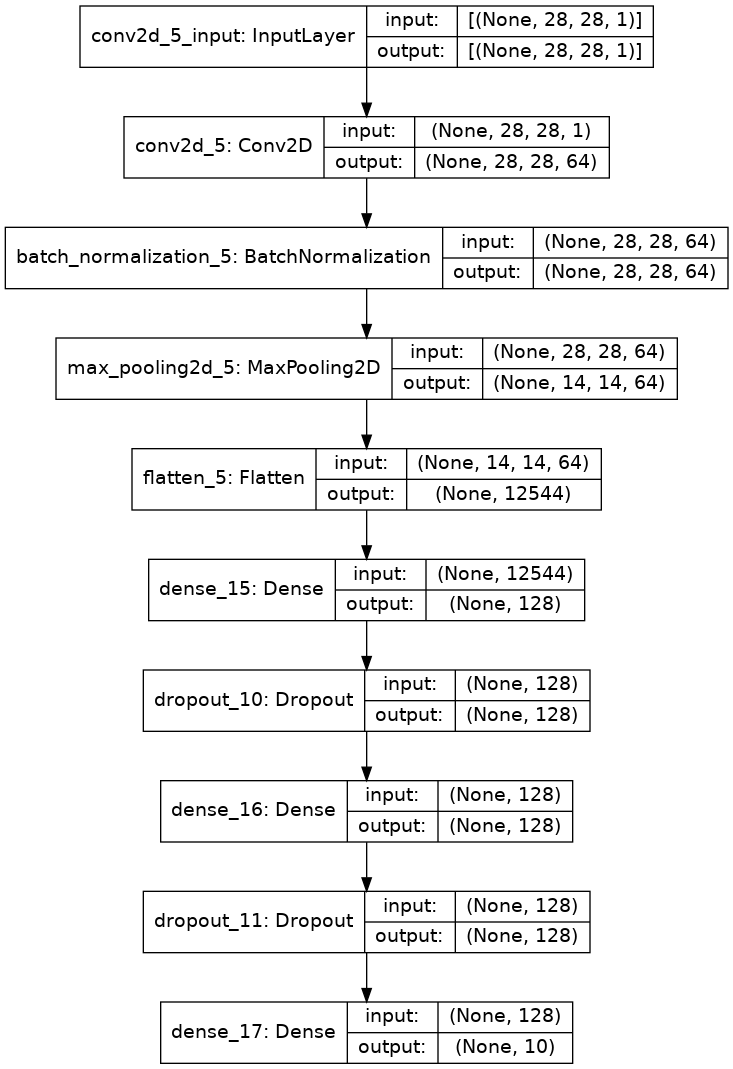

In [32]:
plot_model(build_model(), to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [45]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.MaxPooling2D(2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
best_model_cb = keras.callbacks.ModelCheckpoint("MNIST_bestacc.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy',restore_best_weights=True)

In [48]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3, 4],
    "dropout_rate": [0.2, 0.3, 0,4, 0.5],
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=5, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[best_model_cb, early_stopping_cb])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Epoch 1/100
788/788 [==============================] - 4s 4ms/step - loss: 0.5777 - accuracy: 0.8160 - val_loss: 0.0766 - val_accuracy: 0.9782
Epoch 2/100
788/788 [==============================] - 3s 4ms/step - loss: 0.1069 - accuracy: 0.9689 - val_loss: 0.0746 - val_accuracy: 0.9788
Epoch 3/100
788/788 [==============================] - 3s 4ms/step - loss: 0.0765 - accuracy: 0.9781 - val_loss: 0.0693 - val_accuracy: 0.9795
Epoch 4/100
788/788 [==============================] - 3s 4ms/step - loss: 0.0679 - accuracy: 0.9815 - val_loss: 0.0644 - val_accuracy: 0.9843
Epoch 5/100
788/788 [==============================] - 3s 4ms/step - loss: 0.0491 - accuracy: 0.9854 - val_loss: 0.0644 - val_accuracy: 0.9860
Epoch 6/100
788/788 [==============================] - 3s 4ms/step - loss: 0.0440 - accuracy: 0.9864 - val_loss: 0.0683 - val_accuracy: 0.9855
Epoch 7/100
788/788 [==============================] - 3s 4ms/step - loss: 0.0339

RandomizedSearchCV(cv=5,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc523a0bc50>,
                   param_distributions={'dropout_rate': [0.2, 0.3, 0, 4, 0.5],
                                        'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845...
                                                          0.0006981203125151339,
                                                          0.00

In [56]:
print(rnd_search_cv.best_estimator_, rnd_search_cv.best_score_, rnd_search_cv.best_params_)

<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fc548b4e290> 0.990920615196228 {'n_hidden': 4, 'learning_rate': 0.00180182447899027, 'dropout_rate': 0}


In [59]:
model = keras.models.load_model("MNIST_bestacc.h5")
model

In [60]:
history = model.fit(traingen,epochs=100, validation_data = validgen,
                          callbacks=[best_model_cb, early_stopping_cb])

Epoch 1/100
985/985 [==============================] - 14s 14ms/step - loss: 0.2421 - accuracy: 0.9333 - val_loss: 0.2554 - val_accuracy: 0.9438
Epoch 2/100
985/985 [==============================] - 14s 14ms/step - loss: 0.1141 - accuracy: 0.9668 - val_loss: 0.0236 - val_accuracy: 0.9926
Epoch 3/100
985/985 [==============================] - 15s 15ms/step - loss: 0.0925 - accuracy: 0.9726 - val_loss: 0.0162 - val_accuracy: 0.9948
Epoch 4/100
985/985 [==============================] - 14s 14ms/step - loss: 0.0822 - accuracy: 0.9757 - val_loss: 0.0166 - val_accuracy: 0.9946
Epoch 5/100
985/985 [==============================] - 14s 15ms/step - loss: 0.0776 - accuracy: 0.9766 - val_loss: 0.0132 - val_accuracy: 0.9962
Epoch 6/100
985/985 [==============================] - 14s 14ms/step - loss: 0.0687 - accuracy: 0.9793 - val_loss: 0.0191 - val_accuracy: 0.9939
Epoch 7/100
985/985 [==============================] - 15s 15ms/step - loss: 0.0642 - accuracy: 0.9799 - val_loss: 0.0185 - val_ac

(0.0, 1.0)

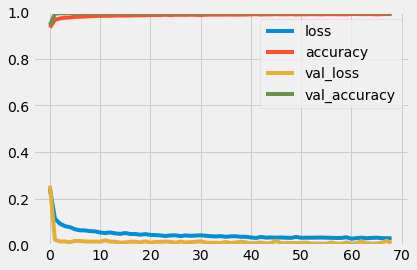

In [61]:
pd.DataFrame(history.history).plot()
plt.ylim([0,1])

In [62]:
y_pred = model.predict_proba(X_train[:3])
print(y_train[:3])
print(y_pred.round(2))

23496    7
24621    0
8951     2
Name: label, dtype: int64
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [63]:
test = test/255
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
model = keras.models.load_model("MNIST_bestacc.h5")
# test = test.values.reshape((-1, 28, 28, 1))
y_pred = model.predict_classes(test)
result = pd.DataFrame({'ImageID':range(1, len(y_pred)+1), 'Label':y_pred})

In [68]:
result.to_csv("MNIST.csv", index=False)